In [1]:
import matplotlib as mpl
#matplotlib.use('Agg')
import os
import datetime
import time
import copy
import shutil
import sys
sys.path.append('/cnrm/pastel/USERS/lecestres/analyse/')
from function_read import *
from HW_detection import *
from forecast_veri import *
import numpy as np
import numpy.random as rnd

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap, shiftgrid
from matplotlib.colors import ListedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import calendar
import locale
locale.setlocale( locale.LC_ALL , 'en_US' )
from netCDF4 import num2date, date2num 
import netCDF4
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import DistanceMetric
from math import radians

from joblib import Parallel, delayed
import joblib

In [2]:
from scipy.stats import pearsonr, spearmanr, linregress

def nanpearsonr(x_input,y_input):
    a=x_input.copy()
    b=y_input.copy()
    x,y = [],[]
    for i in range(len(a)):
        if not(np.isnan(a[i])) and not(np.isnan(b[i])):
            x.append(a[i])
            y.append(b[i])
    return(pearsonr(np.array(x), np.array(y)))

def nanspearmanr(x_input,y_input):
    a=x_input.copy()
    b=y_input.copy()
    x,y = [],[]
    for i in range(len(a)):
        if not(np.isnan(a[i])) and not(np.isnan(b[i])):
            x.append(a[i])
            y.append(b[i])
    return(spearmanr(np.array(x), np.array(y)))

def maskpearsonr(x_input, y_input):
    a=x_input.copy()
    b=y_input.copy()
    if (a.mask!=b.mask).any():
        raise ValueError('Input masks are not identical')
    a.data[a.mask]=np.nan
    b.data[b.mask]=np.nan
    return(nanpearsonr(a.data.flatten(), b.data.flatten()))

def maskspearmanr(x_input, y_input):
    a=x_input.copy()
    b=y_input.copy()
    if (a.mask!=b.mask).any():
        raise ValueError('Input masks are not identical')
    a.data[a.mask]=np.nan
    b.data[b.mask]=np.nan
    return(nanspearmanr(a.data.flatten(), b.data.flatten()))

In [3]:
### EXPERIENCE NAME
expname_ref = "ocean_reanalysis_GREP"
expname_tocompare = "sst_retroprevision_sys7"

### PERCENTILE THRESHOLD
percent_thresh = 95
#percent_thresh = 90

### MINIMAL DURATION OF A HW
duration_min = 5
#duration_min = 3

### REGION OF EXPERIENCE

reg_name = 'north_pacific'
#reg_name = 'north_atlantic'
#reg_name = 'indian_ocean'
#reg_name = 'austral_ocean'
#reg_name = 'tropical_atlantic'
#reg_name = 'tropical_pacific'
#reg_name = 'mediterranee'
#reg_name = 'global'


if reg_name == 'north_pacific':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([120, -120])
    central_lon = 180
    cross_greenwich = False
    cross_antimeridian = True
    reg_name2 = 'Pacific North ocean'
    
if reg_name == 'north_atlantic':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([-80, 0])
    central_lon = 320
    cross_greenwich = False
    cross_antimeridian = False
    reg_name2 = 'Atlantic North ocean'
    
if reg_name == 'indian_ocean':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([45, 110])
    central_lon = 77.5
    cross_greenwich = False
    cross_antimeridian = False
    reg_name2 = 'Indian ocean'
    
if reg_name == 'austral_ocean':
    lats_bnds = np.array([-90,-30])
    lons_bnds = np.array([-180, 180])
    central_lon = 0
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Austral ocean'
    
if reg_name == 'tropical_atlantic':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([-70, 20])
    central_lon = 335
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Atlantic Tropical ocean'
    
if reg_name == 'tropical_pacific':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([120, -70])
    central_lon = -155
    cross_greenwich = False
    cross_antimeridian = True
    reg_name2 = 'Pacific Tropical ocean'
    
if reg_name == 'mediterranee':
    lats_bnds = np.array([30,50])
    lons_bnds = np.array([-5, 40])
    central_lon = 17.5
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Mediterranean sea'
    
if reg_name == 'global':
    lats_bnds = np.array([-90,90])
    lons_bnds = np.array([-180,180])
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Earth'
    
nlat = lats_bnds[1]-lats_bnds[0]
if lons_bnds[1]<lons_bnds[0]:
    nlon = lons_bnds[1]%360-lons_bnds[0]
else:
    nlon = lons_bnds[1]-lons_bnds[0]

### YEARS
if expname_ref == 'ocean_reanalysis_GREP':
    end_year_ref=2016
    start_year_ref=1993
if expname_tocompare == 'sst_retroprevision_sys7':
    end_year_tocompare=2016
    start_year_tocompare=1993

nyear=end_year_tocompare-start_year_tocompare+1

### SEASON
#season = "NDJFMAM"
season = "DJF"
if season == 'NDJFMAM':
    nday = 211
    season_start_day = [11,1] #1stNov
    season_end_day = [5,31] #31stMay
    dayzero = 0
elif season == 'DJF':
    nday = 90
    season_start_day = [12,1] #1stDec
    season_end_day = [3,1] #1stMarch
    first_day = 30
ndayseas = nday//duration_min +1


if expname_ref == "ocean_reanalysis_GREP":    
    ### NUMBER OF MEMBS
    memb_ref=0
    nmemb_ref = 1
    memb_str_ref='memb'+str(memb_ref)
    
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str_ref = "CV"
    else:
        cv_str_ref = 'notCV'
        
if expname_tocompare == "sst_retroprevision_sys7":    
    ### NUMBER OF MEMBS
    memb_start_tocompare=0
    memb_end_tocompare=25
    nmemb_tocompare = memb_end_tocompare-memb_start_tocompare
    membs_str_lst_tocompare=['memb'+str(imemb) for imemb in range(nmemb_tocompare)]
           
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str_tocompare = "CV"
    else:
        cv_str_tocompare = 'notCV'
    
    

### PARAMETERS
parameters_str_ref = reg_name + "_" + season + "_" + cv_str_ref + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_ref, end_year_ref)+'_'+memb_str_ref
# parameters_str_tocompare = reg_name + "_" + season + "_" + cv_str_tocompare + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_tocompare, end_year_tocompare)
# parameters_tocompare defined later because they dpend on each memb

# Amplitude correlation

In [4]:
topath_ref='Ampli_Fields_'+parameters_str_ref
varname_ref = 'Field'
varname2_ref = 'Ampli'
pathHWMI_ref = '/cnrm/pastel/USERS/lecestres/NO_SAVE/data/'+expname_ref+'/'+memb_str_ref+'/'+season+'/'+topath_ref+'/'
files_ref = glob(pathHWMI_ref + '*.nc')
files_ref.sort()

In [5]:
nHW_max=3
Ampli_ref = np.ma.zeros((nHW_max, nyear))
Fields_ref = np.ma.zeros((nHW_max, nyear, nlat, nlon))
for iyear, file_ref in enumerate(files_ref[:]):
    varf_ref=netCDF4.Dataset(file_ref)
    Fields_ref_iyear=varf_ref[varname_ref][:]
    Ampli_ref_iyear=varf_ref[varname2_ref][:]
    lats_reg=varf_ref['lat'][:]
    lons_reg=varf_ref['lon'][:]
    varf_ref.close()
    nHW_i, ndayseas_i = Ampli_ref_iyear.shape
    if ndayseas != ndayseas_i:
        print('WARNING : ndayseas has been set to ', ndayseas,' but is equal to ', ndayseas_i)
    total_ampli_iyear = np.ma.sum(Ampli_ref_iyear, axis = 1)
    fieldssum_iyear = area_av(Fields_ref_iyear, 1,2, lats_reg, lons_reg)
    args_max_ampli = np.flip(np.argsort(total_ampli_iyear))
    args_max_field = np.flip(np.argsort(fieldssum_iyear))
    if (args_max_ampli[:nHW_max]!=args_max_field[:nHW_max]).all():
        print('WARNING : issue finding the biggest HWs of the iyear : ', iyear)
    for jHW in range(nHW_max):
        Ampli_ref[jHW,iyear]=total_ampli_iyear[args_max_ampli[jHW]]
        Fields_ref[jHW,iyear,:,:]=Fields_ref_iyear[args_max_ampli[jHW],:,:]

In [6]:
Ampli_tocompare = np.ma.zeros((nHW_max, nyear, nmemb_tocompare))
Fields_tocompare = np.ma.zeros((nHW_max, nyear, nmemb_tocompare, nlat, nlon))
files_tocompare_all=[]
for jmemb, jmemb_str in enumerate(membs_str_lst_tocompare):
    parameters_str_tocompare=reg_name+"_"+season+"_"+cv_str_tocompare+'_percent%i'%(percent_thresh)+'_daymin%i'%(duration_min)+"_ref%i-%i"%(start_year_tocompare, end_year_tocompare)+'_'+jmemb_str
    topath_tocompare='Ampli_Fields_'+parameters_str_tocompare
    varname_tocompare = 'Field'
    varname2_tocompare = 'Ampli'
    pathHWMI_tocompare_jmemb = '/cnrm/pastel/USERS/lecestres/NO_SAVE/data/'+expname_tocompare+'/'+jmemb_str+'/'+season+'/'+topath_tocompare+'/'
    files_tocompare_jmemb = glob(pathHWMI_tocompare_jmemb + '*.nc')
    files_tocompare_jmemb.sort()
    files_tocompare_all.append(files_tocompare_jmemb)
    for iyear, file_tocompare in enumerate(files_tocompare_jmemb[:]):
        varf_tocompare=netCDF4.Dataset(file_tocompare)
        Fields_tocompare_iyear_jmemb=varf_tocompare[varname_tocompare][:]
        Ampli_tocompare_iyear_jmemb=varf_tocompare[varname2_tocompare][:]
        lats_reg=varf_ref['lat'][:]
        lons_reg=varf_ref['lon'][:]
        varf_tocompare.close()
        nHW_i_j, ndayseas_i_j = Ampli_tocompare_iyear_jmemb.shape
        if ndayseas != ndayseas_i_j:
            print('WARNING : ndayseas has been set to ', ndayseas,' but is equal to ', ndayseas_i_j)
        total_ampli_iyear_jmemb = np.ma.sum(Ampli_tocompare_iyear_jmemb, axis=1)
        fieldssum_iyear_jmemb = area_av(Fields_tocompare_iyear_jmemb,1,2,lats_reg,lons_reg)
        args_max_ampli = np.flip(np.argsort(total_ampli_iyear_jmemb))
        args_max_field = np.flip(np.argsort(fieldssum_iyear_jmemb))
        if (args_max_ampli[:nHW_max]!=args_max_field[:nHW_max]).all():
            print('WARNING : issue finding the biggest HWs of the iyear, jmemb : ', iyear,jmemb)
        nHW_tmp=min(nHW_max,len(args_max_ampli))
        for lHW in range(nHW_tmp):
            Ampli_tocompare[lHW,iyear,jmemb]=total_ampli_iyear_jmemb[args_max_ampli[lHW]]
            Fields_tocompare[lHW,iyear,jmemb,:,:]=Fields_tocompare_iyear_jmemb[args_max_field[lHW],:,:]

In [7]:
Ampli_mean_tocompare = np.ma.mean(Ampli_tocompare, axis=2)
Fields_mean_tocompare = np.ma.mean(Fields_tocompare, axis=2)
Fields_mean_tocompare.mask = Fields_tocompare.mask[:,:,0,:,:]

maskunion = np.zeros((nlat,nlon))
for i in range(nlat):
    for j in range(nlon):
        trueref = Fields_mean_tocompare.mask[0,0,i,j]
        truetocomp = Fields_ref.mask[0,0,i,j]
        maskunion[i,j] = trueref or truetocomp

for hw in range(nHW_max):
    for i in range(nyear):
        Fields_mean_tocompare.mask[hw,i,:,:]=maskunion
        Fields_ref.mask[hw,i,:,:] = maskunion

In [8]:
def predtrend(y):
    nyear, = y.shape
    x=np.arange(nyear)
    modtrend = np.zeros(nyear)
    cortrend = np.zeros((2))
    for iyear in range(nyear):
        xcv=np.delete(x, iyear)
        ycv=np.delete(y, iyear)
        #print(xcv.shape, ycv.shape)
        linreg = linregress(xcv, ycv)
        modtrend[iyear] = x[iyear]*linreg.slope+linreg.intercept
    cortrend[:]=pearsonr(y[:], modtrend[:])
    return(modtrend, cortrend)

# Keeping the 1st biggest HW

In [9]:
year_to_plot=np.random.randint(start_year_ref,end_year_ref+1)
year_to_plot=2014

In [10]:
Ampli_modtrend, Amplicortrend = predtrend(Ampli_ref[0,:])
Ampli_cor_tocompare = pearsonr(Ampli_ref[0,:],Ampli_mean_tocompare[0,:])
Field_cor = np.zeros((nyear,2))
Field_cor_spearman = np.zeros((nyear,2))
bullshit = np.zeros((nyear,2))
for iyear in range(nyear):
    bullshit[iyear,:] = pearsonr(Fields_mean_tocompare[0,iyear,:,:].flatten(), Fields_ref[0,iyear,:,:].flatten())
    Field_cor[iyear,:] = maskpearsonr(Fields_mean_tocompare[0,iyear,:,:], Fields_ref[0,iyear,:,:])
    Field_cor_spearman[iyear,:] = maskspearmanr(Fields_mean_tocompare[0,iyear,:,:], Fields_ref[0,iyear,:,:])

In [11]:
print(bullshit[:,0], Field_cor[:,0])
bullshit[:,0] < Field_cor[:,0]

[-0.06795963 -0.20841604 -0.22824886 -0.24510742 -0.10995777 -0.29666673
 -0.24017055 -0.20024662 -0.23672225 -0.18153153 -0.17770749 -0.28682429
 -0.30868325 -0.27455952 -0.18713673 -0.18254885 -0.20041851 -0.20236079
 -0.25416349 -0.17811814 -0.24299562 -0.31564088 -0.24084033 -0.16939413] [ 0.07770082  0.05842758 -0.07251315  0.71386514  0.77154067  0.1271418
  0.36740972 -0.04635268  0.07172624  0.26910374 -0.03780506  0.62670339
  0.16286053  0.01418366  0.10813705 -0.01070213  0.02622705  0.43635837
  0.25138379  0.09545257  0.84496321  0.29041155 -0.09481692  0.48292077]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [12]:
cmap = mpl.cm.Reds
color = cmap(np.linspace(0,1,256))
white = np.array([1,1,1,1])
color[:5, :] = white
newcmp = ListedColormap(color)
bounds = np.linspace(0,20,21)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)
norm = mpl.colors.BoundaryNorm(bounds, newcmp.N, clip=True)

In [13]:
def plotfield(ax, lon, lat, field, title): #, title, bounds, cmin, cmax, cmap, norm, cbar=True, signi=False, signicor=False, extend="neither"):
    #ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    if cross_greenwich:
        lon[lon>180]=lon[lon>180]-360
    elif cross_antimeridian:
        #lat[lat>180]=lat[lat>180]-360
        lon[lon<0]=lon[lon<0]+360
    lon2d, lat2d = np.meshgrid(lon, lat)
    ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    plot = ax.contourf(lon2d, lat2d, field, bounds, transform=ccrs.PlateCarree(), cmap = newcmp, norm=norm, extend='both')
    cbar = fig.colorbar(plot, orientation = 'horizontal', ax=ax, shrink=0.8, spacing='proportional', ticks=[0,10,20])
    ax.set_title(title, fontsize= 10)

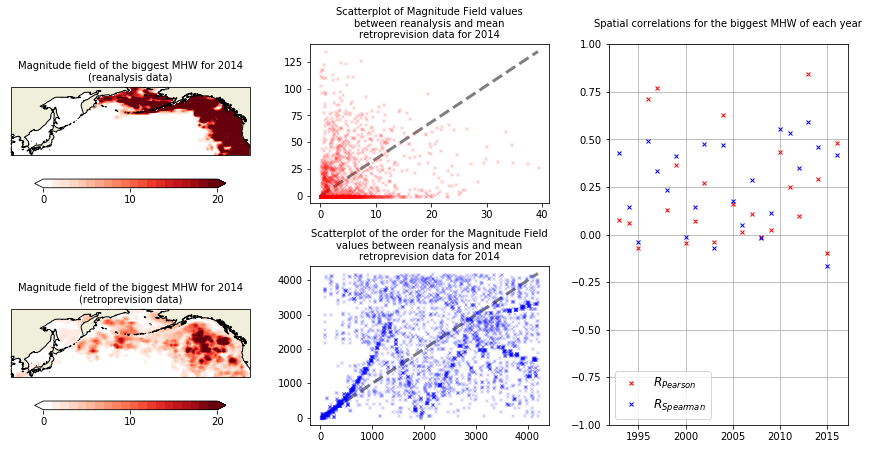

In [14]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)
str_year=str(year_to_plot)

fig = plt.figure(constrained_layout=False, figsize = (15,7))

gs = gridspec.GridSpec(2, 3, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[:,2])

ax1.plot(range_year, Field_cor[:,0], 'rx', markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$')
ax1.plot(range_year, Field_cor_spearman[:,0], 'bx', markersize=4*coeff, alpha = 1 , label = r'${R_{Spearman}}$')
ax1.grid()
ax1.tick_params(axis='both', labelsize=10*coeff)

ax1.set_ylim((-1,1))
ax1.legend(fontsize = 12*coeff)
ax1.set_title('Spatial correlations for the biggest MHW of each year', fontsize = 10*coeff, y=1.03)

ax2 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax2, lons_reg, lats_reg, Fields_ref[0,year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')

ax3 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax3, lons_reg, lats_reg, Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(retroprevision data)')

ax4 = plt.subplot(gs[0,1])
line4 = [np.max(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:]), np.max(Fields_ref[0,year_to_plot-start_year_ref,:,:])]
ax4.plot([0,line4[0]],[0, line4[1]], 'k--', linewidth=3, alpha=0.5)
ax4.plot(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:].flatten(), Fields_ref[0,year_to_plot-start_year_ref,:,:].flatten(), 'rx', markersize=3, alpha=0.2)
ax4.set_title('Scatterplot of Magnitude Field values\nbetween reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


ax5 = plt.subplot(gs[1,1])
line5 = len(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:].flatten())
ax5.plot([0,line5],[0, line5], 'k--', linewidth=3, alpha=0.5)
ax5.plot(np.argsort(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:].flatten()), np.argsort(Fields_ref[0,year_to_plot-start_year_ref,:,:].flatten()), 'bx', markersize=3, alpha=0.2)
ax5.set_title('Scatterplot of the order for the Magnitude Field\nvalues between reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


export_path='Correlation_results_'+reg_name
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')


# Concatenate nHW_max for each year

In [15]:
Fields_ref_concatenate=np.ma.sum(Fields_ref, axis=0)
Fields_mean_tocompare_concatenate=np.ma.sum(Fields_mean_tocompare, axis=0)
Field_cor_concatenate = np.zeros((nyear,2))
Field_cor_concatenate_spearman = np.zeros((nyear,2))
bullshit = np.zeros((nyear,2))

In [16]:
for iyear in range(nyear):
    bullshit[iyear,:] = pearsonr(Fields_mean_tocompare_concatenate[iyear,:,:].flatten(), Fields_ref_concatenate[iyear,:,:].flatten())
    Field_cor_concatenate[iyear,:] = maskpearsonr(Fields_mean_tocompare_concatenate[iyear,:,:], Fields_ref_concatenate[iyear,:,:])
    Field_cor_concatenate_spearman[iyear,:] = maskspearmanr(Fields_mean_tocompare_concatenate[iyear,:,:], Fields_ref_concatenate[iyear,:,:])

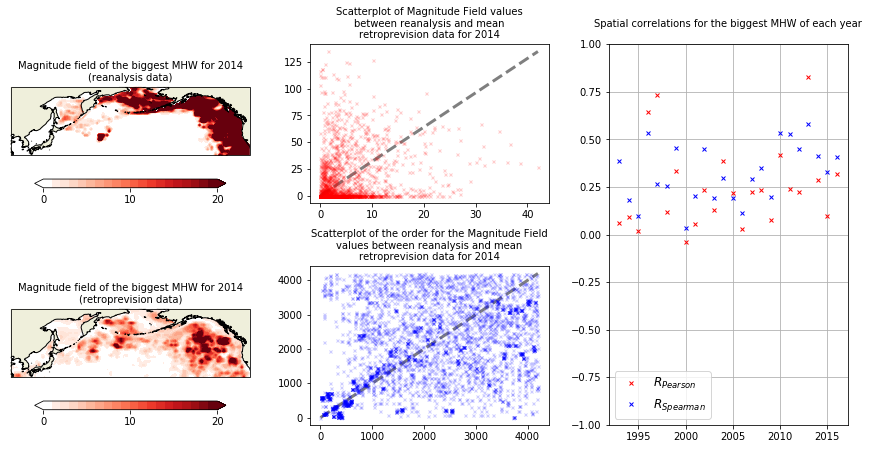

In [17]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)

fig = plt.figure(constrained_layout=False, figsize = (15,7))

gs = gridspec.GridSpec(2, 3, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[:,2])

ax1.plot(range_year, Field_cor_concatenate[:,0], 'rx', markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$')
ax1.plot(range_year, Field_cor_concatenate_spearman[:,0], 'bx', markersize=4*coeff, alpha = 1 , label = r'${R_{Spearman}}$')
ax1.grid()
ax1.tick_params(axis='both', labelsize=10*coeff)

ax1.set_ylim((-1,1))
ax1.legend(fontsize = 12*coeff)
ax1.set_title('Spatial correlations for the biggest MHW of each year', fontsize = 10*coeff, y=1.03)

ax2 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax2, lons_reg, lats_reg, Fields_ref_concatenate[year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')

ax3 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax3, lons_reg, lats_reg, Fields_mean_tocompare_concatenate[year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(retroprevision data)')

ax4 = plt.subplot(gs[0,1])
line4 = [np.max(Fields_mean_tocompare_concatenate[year_to_plot-start_year_ref,:,:]), np.max(Fields_ref_concatenate[year_to_plot-start_year_ref,:,:])]
ax4.plot([0,line4[0]],[0, line4[1]], 'k--', linewidth=3, alpha=0.5)
ax4.plot(Fields_mean_tocompare_concatenate[year_to_plot-start_year_ref,:,:].flatten(), Fields_ref_concatenate[year_to_plot-start_year_ref,:,:].flatten(), 'rx', markersize=3, alpha=0.2)
ax4.set_title('Scatterplot of Magnitude Field values\nbetween reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


ax5 = plt.subplot(gs[1,1])
line5 = len(Fields_mean_tocompare_concatenate[year_to_plot-start_year_ref,:,:].flatten())
ax5.plot([0,line5],[0, line5], 'k--', linewidth=3, alpha=0.5)
ax5.plot(np.argsort(Fields_mean_tocompare_concatenate[year_to_plot-start_year_ref,:,:].flatten()), np.argsort(Fields_ref_concatenate[year_to_plot-start_year_ref,:,:].flatten()), 'bx', markersize=3, alpha=0.2)
ax5.set_title('Scatterplot of the order for the Magnitude Field\nvalues between reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


export_path='Correlation_results_'+reg_name
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')

# Absolut threshold

In [18]:
cmap2 = mpl.cm.Reds
color2 = cmap(np.linspace(0,1,256))
newcmp2 = ListedColormap(color2)
bounds2 = np.linspace(0,1,3)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)
norm2 = mpl.colors.BoundaryNorm(bounds2, newcmp2.N, clip=True)

def plotfield2(ax, lon, lat, field, title): #, title, bounds, cmin, cmax, cmap, norm, cbar=True, signi=False, signicor=False, extend="neither"):
    #ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    if cross_greenwich:
        lon[lon>180]=lon[lon>180]-360
    elif cross_antimeridian:
        #lat[lat>180]=lat[lat>180]-360
        lon[lon<0]=lon[lon<0]+360
    lon2d, lat2d = np.meshgrid(lon, lat)
    ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    plot = ax.contourf(lon2d, lat2d, field, bounds2, transform=ccrs.PlateCarree(), cmap = newcmp2, norm=norm2, extend='both')
    cbar = fig.colorbar(plot, orientation = 'horizontal', ax=ax, shrink=0.5, spacing='proportional', ticks=[0,1])
    ax.set_title(title, fontsize= 10)

In [19]:
Field_cor_absthresh = np.zeros((nyear,2))
Field_cor_absthresh_spearman = np.zeros((nyear,2))

Fields_mean_tocompare_absthresh = Fields_mean_tocompare_concatenate.copy()
Fields_ref_absthresh = Fields_ref_concatenate.copy()

In [20]:
seuil=5
Fields_mean_tocompare_absthresh.data[Fields_mean_tocompare_absthresh.data<=seuil]=0
Fields_mean_tocompare_absthresh.data[Fields_mean_tocompare_absthresh.data>seuil]=1
Fields_ref_absthresh.data[Fields_ref_absthresh.data<=seuil]=0
Fields_ref_absthresh.data[Fields_ref_absthresh.data>seuil]=1

In [21]:
for iyear in range(nyear):
    Field_cor_absthresh[iyear,:] = maskpearsonr(Fields_mean_tocompare_absthresh[iyear,:,:], Fields_ref_absthresh[iyear,:,:])
    Field_cor_absthresh_spearman[iyear,:] = maskspearmanr(Fields_mean_tocompare_absthresh[iyear,:,:], Fields_ref_absthresh[iyear,:,:])

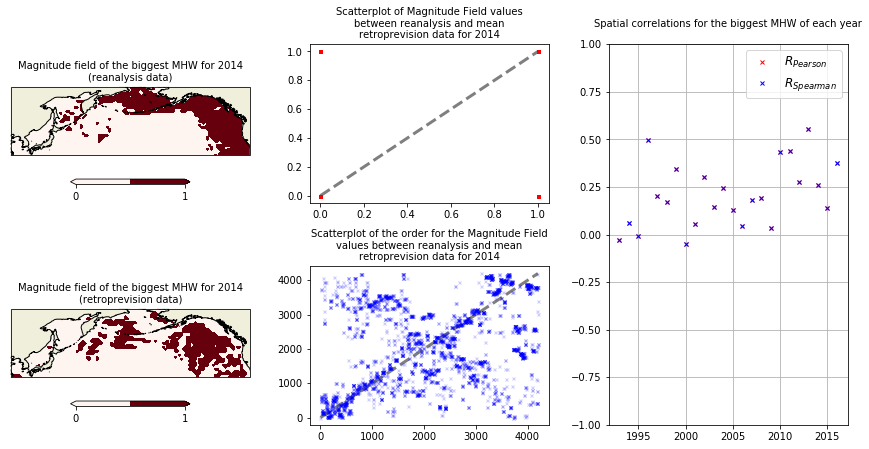

In [22]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)
str_year=str(year_to_plot)

fig = plt.figure(constrained_layout=False, figsize = (15,7))

gs = gridspec.GridSpec(2, 3, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[:,2])

ax1.plot(range_year, Field_cor_absthresh[:,0], 'rx', markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$')
ax1.plot(range_year, Field_cor_absthresh_spearman[:,0], 'bx', markersize=4*coeff, alpha = 1 , label = r'${R_{Spearman}}$')
ax1.grid()
ax1.tick_params(axis='both', labelsize=10*coeff)

ax1.set_ylim((-1,1))
ax1.legend(fontsize = 12*coeff)
ax1.set_title('Spatial correlations for the biggest MHW of each year', fontsize = 10*coeff, y=1.03)

ax2 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax2, lons_reg, lats_reg, Fields_ref_absthresh[year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')

ax3 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax3, lons_reg, lats_reg, Fields_mean_tocompare_absthresh[year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(retroprevision data)')

ax4 = plt.subplot(gs[0,1])
line4 = [np.max(Fields_mean_tocompare_absthresh[year_to_plot-start_year_ref,:,:]), np.max(Fields_ref_absthresh[year_to_plot-start_year_ref,:,:])]
ax4.plot([0,line4[0]],[0, line4[1]], 'k--', linewidth=3, alpha=0.5)
ax4.plot(Fields_mean_tocompare_absthresh[year_to_plot-start_year_ref,:,:].flatten(), Fields_ref_absthresh[year_to_plot-start_year_ref,:,:].flatten(), 'rx', markersize=3, alpha=0.2)
ax4.set_title('Scatterplot of Magnitude Field values\nbetween reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


ax5 = plt.subplot(gs[1,1])
line5 = len(Fields_mean_tocompare_absthresh[year_to_plot-start_year_ref,:,:].flatten())
ax5.plot([0,line5],[0, line5], 'k--', linewidth=3, alpha=0.5)
ax5.plot(np.argsort(Fields_mean_tocompare_absthresh[year_to_plot-start_year_ref,:,:].flatten()), np.argsort(Fields_ref_absthresh[year_to_plot-start_year_ref,:,:].flatten()), 'bx', markersize=3, alpha=0.2)
ax5.set_title('Scatterplot of the order for the Magnitude Field\nvalues between reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


export_path='Correlation_results_'+reg_name
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')

# Chosing the perc_value

In [23]:
perc_tab=[50,55,60,65,70,75,80,85,90]
nperc = len(perc_tab)
npercs_tocompare = []
npercs_ref = []
for perc in perc_tab:
    Tocomputeperc_mean_tocompare = []
    Tocomputeperc_ref = []
    for iyear in range(nyear):
        Tocomputeperc_mean_tocompare.append(Fields_mean_tocompare_concatenate.data[iyear][Fields_mean_tocompare_concatenate.mask[iyear] == False].copy())
        Tocomputeperc_ref.append(Fields_ref_concatenate.data[iyear][Fields_ref_concatenate.mask[iyear] == False])
    Tocomputeperc_mean_tocompare = np.array(Tocomputeperc_mean_tocompare)
    Tocomputeperc_ref = np.array(Tocomputeperc_ref)
    perc_tocompare = np.percentile(Tocomputeperc_mean_tocompare, perc, axis=1)
    perc_ref = np.percentile(Tocomputeperc_ref, perc, axis=1)
    npercs_tocompare.append(perc_tocompare)
    npercs_ref.append(perc_ref)
npercs_ref=np.array(npercs_ref)
npercs_tocompare=np.array(npercs_tocompare)

In [24]:
npercs_tocompare.shape

(9, 24)

In [25]:
Field_many_percthresholded_cor = np.zeros((nperc,nyear,2))
Field_many_percthresholded_cor_spearman = np.zeros((nperc,nyear,2))

for iperc,perc in enumerate(perc_tab):
    Fields_tmp_mean_tocompare = Fields_mean_tocompare_concatenate.copy()
    Fields_tmp_ref = Fields_ref_concatenate.copy()
    for iyear in range(nyear):
        Fields_tmp_mean_tocompare.data[iyear][Fields_tmp_mean_tocompare.data[iyear]<=npercs_tocompare[iperc,iyear]]=0
        Fields_tmp_ref.data[iyear][Fields_tmp_ref.data[iyear]<=npercs_ref[iperc,iyear]]=0
        Fields_tmp_mean_tocompare.data[iyear][Fields_tmp_mean_tocompare.data[iyear]>npercs_tocompare[iperc,iyear]]=1
        Fields_tmp_ref.data[iyear][Fields_tmp_ref.data[iyear]>npercs_ref[iperc,iyear]]=1
        Field_many_percthresholded_cor[iperc,iyear,:] = maskpearsonr(Fields_tmp_mean_tocompare[iyear,:,:], Fields_tmp_ref[iyear,:,:])
        Field_many_percthresholded_cor_spearman[iperc,iyear,:] = maskspearmanr(Fields_tmp_mean_tocompare[iyear,:,:], Fields_tmp_ref[iyear,:,:])

Text(0.5,1.03,'Spatial correlations score for different percentiles')

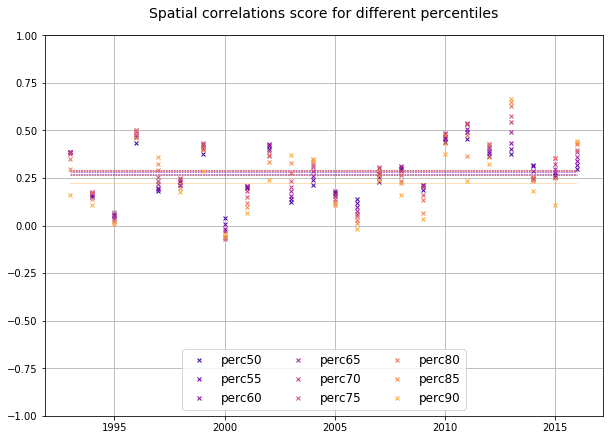

In [26]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)
cmap = mpl.cm.plasma
color = cmap(np.linspace(0.1,0.8,nperc))

fig = plt.figure(constrained_layout=False, figsize = (10,7))
gs = gridspec.GridSpec(1,1, figure = fig)
ax0 = plt.subplot(gs[:,:])

for iperc,perc in enumerate(perc_tab):
    xdata = (start_year_ref,end_year_ref)
    mean_score = np.mean(Field_many_percthresholded_cor[iperc,:,0])
    ydata=(mean_score,mean_score)
    line = Line2D(xdata,ydata,alpha=1, color=color[iperc],linestyle='--',linewidth=0.5*coeff)
    ax0.add_line(line)
    ax0.plot(range_year, Field_many_percthresholded_cor[iperc,:,0], 'x', color=color[iperc], markersize=4*coeff, alpha = 1 , label = 'perc'+str(perc))
    

ax0.grid()
ax0.tick_params(axis='both', labelsize=10*coeff)
ax0.set_ylim((-1,1))
ax0.legend(fontsize = 12*coeff, ncol = 3,loc='lower center')
ax0.set_title('Spatial correlations score for different percentiles', fontsize = 14*coeff, y=1.03)

In [27]:
np.mean(Field_many_percthresholded_cor[:,:,0], axis=1), perc_tab[np.argmax(np.mean(Field_many_percthresholded_cor[:,:,0], axis=1))]

(array([0.26331931, 0.2733096 , 0.27994904, 0.28507088, 0.29116203,
        0.2922485 , 0.28664515, 0.26339988, 0.22464856]), 75)

# Percent seuil

In [28]:
perc=80
Tocomputeperc_mean_tocompare = []
Tocomputeperc_ref = []
for iyear in range(nyear):
    Tocomputeperc_mean_tocompare.append(Fields_mean_tocompare_concatenate.data[iyear][Fields_mean_tocompare_concatenate.mask[iyear] == False].copy())
    Tocomputeperc_ref.append(Fields_ref_concatenate.data[iyear][Fields_ref_concatenate.mask[iyear] == False])
Tocomputeperc_mean_tocompare = np.array(Tocomputeperc_mean_tocompare)
Tocomputeperc_ref = np.array(Tocomputeperc_ref)
perc_tocompare = np.percentile(Tocomputeperc_mean_tocompare, perc, axis=1)
perc_ref = np.percentile(Tocomputeperc_ref, perc, axis=1)

In [29]:
Field_percthresholded_cor = np.zeros((nyear,2))
Field_percthresholded_cor_spearman = np.zeros((nyear,2))
Fields_mean_tocompare_percthresholded = Fields_mean_tocompare_concatenate.copy()
Fields_ref_percthresholded = Fields_ref_concatenate.copy()

In [30]:
for iyear in range(nyear):
    Fields_mean_tocompare_percthresholded.data[iyear][Fields_mean_tocompare_percthresholded.data[iyear]<=perc_tocompare[iyear]]=0
    Fields_ref_percthresholded.data[iyear][Fields_ref_percthresholded.data[iyear]<=perc_ref[iyear]]=0
    Fields_mean_tocompare_percthresholded.data[iyear][Fields_mean_tocompare_percthresholded.data[iyear]>perc_tocompare[iyear]]=1
    Fields_ref_percthresholded.data[iyear][Fields_ref_percthresholded.data[iyear]>perc_ref[iyear]]=1
    Field_percthresholded_cor[iyear,:] = maskpearsonr(Fields_mean_tocompare_percthresholded[iyear,:,:], Fields_ref_percthresholded[iyear,:,:])
    Field_percthresholded_cor_spearman[iyear,:] = maskspearmanr(Fields_mean_tocompare_percthresholded[iyear,:,:], Fields_ref_percthresholded[iyear,:,:])

In [31]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)

fig = plt.figure(constrained_layout=False, figsize = (15,7))

gs = gridspec.GridSpec(2, 3, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[:,2])

ax1.plot(range_year, Field_percthresholded_cor[:,0], 'rx', markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$')
ax1.plot(range_year, Field_percthresholded_cor_spearman[:,0], 'bx', markersize=4*coeff, alpha = 1 , label = r'${R_{Spearman}}$')
ax1.grid()
ax1.tick_params(axis='both', labelsize=10*coeff)

ax1.set_ylim((-1,1))
ax1.legend(fontsize = 12*coeff)
ax1.set_title('Spatial correlations for the biggest MHW of each year', fontsize = 10*coeff, y=1.03)

ax2 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax2, lons_reg, lats_reg, Fields_ref_percthresholded[year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')

ax3 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax3, lons_reg, lats_reg, Fields_mean_tocompare_percthresholded[year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(retroprevision data)')

ax4 = plt.subplot(gs[0,1])
line4 = [np.max(Fields_mean_tocompare_percthresholded[year_to_plot-start_year_ref,:,:]), np.max(Fields_ref_percthresholded[year_to_plot-start_year_ref,:,:])]
ax4.plot([0,line4[0]],[0, line4[1]], 'k--', linewidth=3, alpha=0.5)
ax4.plot(Fields_mean_tocompare_percthresholded[year_to_plot-start_year_ref,:,:].flatten(), Fields_ref_percthresholded[year_to_plot-start_year_ref,:,:].flatten(), 'rx', markersize=3, alpha=0.2)
ax4.set_title('Scatterplot of Magnitude Field values\nbetween reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


ax5 = plt.subplot(gs[1,1])
line5 = len(Fields_mean_tocompare_percthresholded[year_to_plot-start_year_ref,:,:].flatten())
ax5.plot([0,line5],[0, line5], 'k--', linewidth=3, alpha=0.5)
ax5.plot(np.argsort(Fields_mean_tocompare_percthresholded[year_to_plot-start_year_ref,:,:].flatten()), np.argsort(Fields_ref_percthresholded[year_to_plot-start_year_ref,:,:].flatten()), 'bx', markersize=3, alpha=0.2)
ax5.set_title('Scatterplot of the order for the Magnitude Field\nvalues between reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


export_path='Correlation_results_'+reg_name
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')

TopologyException: side location conflict at 179.5 61.5


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fea346e98d0>

TopologyException: side location conflict at 179.5 61.5


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fea53dc1f80> (for post_execute):


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fea34fbc390>

TopologyException: side location conflict at 179.5 61.5


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fea351be490>

<Figure size 1080x504 with 2 Axes>

# Plot Spatial correlation score

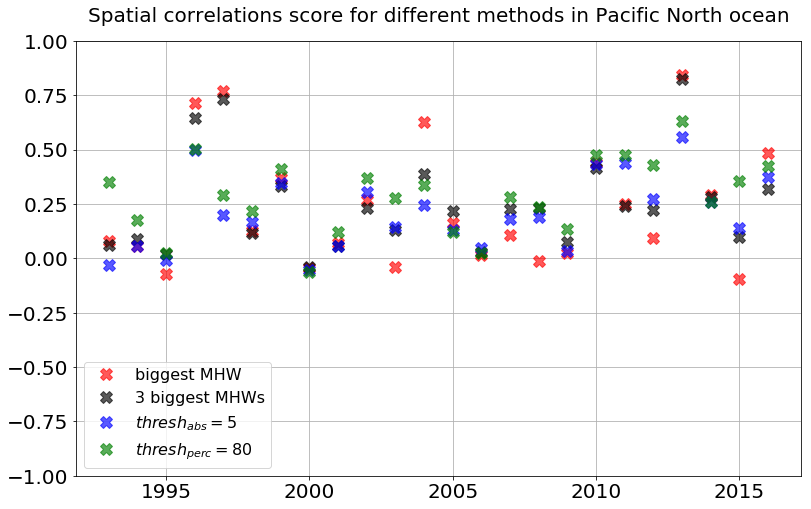

In [32]:
coeff = 2
range_year = range(start_year_ref, end_year_ref+1)

fig = plt.figure(constrained_layout=False, figsize = (13,8))

gs = gridspec.GridSpec(1, 1, hspace=0.7, wspace=0.25, figure = fig)

cmap = mpl.cm.winter
color = cmap(np.linspace(0.3,0.7,4))
color = ['r','k','b','g']
ax0 = plt.subplot(gs[:,:])
ax0.plot(range_year, Field_cor[:,0], 'X', color=color[0], markersize=6*coeff, alpha = 0.65 , label = 'biggest MHW')
ax0.plot(range_year, Field_cor_concatenate[:,0], 'X', color=color[1], markersize=6*coeff, alpha = 0.65 , label = str(nHW_max)+' biggest MHWs')
ax0.plot(range_year, Field_cor_absthresh[:,0], 'X', color=color[2], markersize=6*coeff, alpha = 0.65 , label = r'$thresh_{abs} = $'+str(seuil))
ax0.plot(range_year, Field_percthresholded_cor[:,0], 'X', color=color[3], markersize=6*coeff, alpha = 0.65 , label = r'$thresh_{perc} = $'+str(perc))
ax0.grid()
ax0.tick_params(axis='both', labelsize=10*coeff)
ax0.set_ylim((-1,1))
ax0.legend(fontsize = 8*coeff, loc='lower left')
ax0.set_title('Spatial correlations score for different methods in '+reg_name2, fontsize = 10*coeff, y=1.03)
    
export_path='Scores_spatial_corr_'+reg_name
plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/spatial_amplitude/'+export_path+'.pdf')

# Superplot

In [33]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)

fig = plt.figure(constrained_layout=False, figsize = (20,140))

gs = gridspec.GridSpec(nyear*2+2, 4, hspace=0.7, wspace=0.25, figure = fig)

cmap = mpl.cm.Purples
color = cmap(np.linspace(0.5,1,4))
ax0 = plt.subplot(gs[:2,1:-1])
ax0.plot(range_year, Field_cor[:,0], 'x', color=color[0], markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$ 1st MHW')
ax0.plot(range_year, Field_cor_concatenate[:,0], 'x', color=color[1], markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$'+str(nHW_max)+'th MHW')
ax0.plot(range_year, Field_cor_absthresh[:,0], 'x', color=color[2], markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$ abs_thresh = '+str(seuil))
ax0.plot(range_year, Field_percthresholded_cor[:,0], 'x', color=color[3], markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$ perc_thresh = '+str(perc))
ax0.grid()
ax0.tick_params(axis='both', labelsize=10*coeff)
ax0.set_ylim((-1,1))
ax0.legend(fontsize = 12*coeff)
ax0.set_title('Spatial correlations score for different methods', fontsize = 10*coeff, y=1.03)

for iyear in range(nyear):
    str_year=str(iyear+start_year_ref)
    ax_i1_ref = plt.subplot(gs[2*(iyear+1),0], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield(ax_i1_ref, lons_reg, lats_reg, Fields_ref[0,iyear,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')
    ax_i1_tocompare= plt.subplot(gs[2*(iyear+1)+1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield(ax_i1_tocompare, lons_reg, lats_reg, Fields_mean_tocompare[0,iyear,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(hindcast data)')
    
    ax_i2_ref = plt.subplot(gs[2*(iyear+1),1], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield(ax_i2_ref, lons_reg, lats_reg, Fields_ref_concatenate[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs for '+str_year+'\n(reanalysis data)')
    ax_i2_tocompare = plt.subplot(gs[2*(iyear+1)+1,1], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield(ax_i2_tocompare, lons_reg, lats_reg, Fields_mean_tocompare_concatenate[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs for '+str_year+'\n(hindcast data)')

    ax_i3_ref = plt.subplot(gs[2*(iyear+1),2], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield2(ax_i3_ref, lons_reg, lats_reg, Fields_ref_absthresh[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs\nwith an absolute threshold\nfor '+str_year+'\n(reanalysis data)')
    ax_i3_tocompare = plt.subplot(gs[2*(iyear+1)+1,2], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield2(ax_i3_tocompare, lons_reg, lats_reg, Fields_mean_tocompare_absthresh[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs\nwith an absolute threshold\nfor '+str_year+'\n(hindcast data)')

    ax_i4_ref = plt.subplot(gs[2*(iyear+1),3], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield2(ax_i4_ref, lons_reg, lats_reg, Fields_ref_percthresholded[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs\nwith an percentile threshold\nfor '+str_year+'\n(reanalysis data)')
    ax_i4_tocompare = plt.subplot(gs[2*(iyear+1)+1,3], projection=ccrs.PlateCarree(central_longitude=central_lon))
    plotfield2(ax_i4_tocompare, lons_reg, lats_reg, Fields_mean_tocompare_percthresholded[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs\nwith an percentile threshold\nfor '+str_year+'\n(reanalysis data)')
    
export_path='Spatial_corr_super_plot'+reg_name
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')

TopologyException: side location conflict at 179.5 61.5


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fea291a9190>

TopologyException: side location conflict at 179.5 61.5


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fea53dc1f80> (for post_execute):


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fea248cef10>

TopologyException: side location conflict at 179.5 61.5


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fea24998710>

<Figure size 1440x10080 with 350 Axes>

# Specific year

In [34]:
year = 2015
str_year=str(year)
iyear=year-start_year_ref

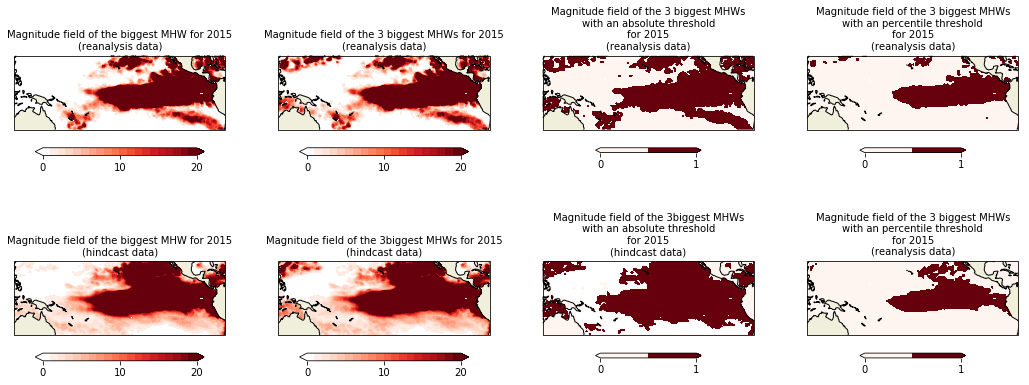

In [35]:
fig = plt.figure(constrained_layout=False, figsize = (18,6))
gs = gridspec.GridSpec(2, 4, hspace=0.7, wspace=0.25, figure = fig)
ax_i1_ref = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax_i1_ref, lons_reg, lats_reg, Fields_ref[0,iyear,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')
ax_i1_tocompare= plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax_i1_tocompare, lons_reg, lats_reg, Fields_mean_tocompare[0,iyear,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(hindcast data)')
ax_i2_ref = plt.subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax_i2_ref, lons_reg, lats_reg, Fields_ref_concatenate[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+' biggest MHWs for '+str_year+'\n(reanalysis data)')
ax_i2_tocompare = plt.subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax_i2_tocompare, lons_reg, lats_reg, Fields_mean_tocompare_concatenate[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs for '+str_year+'\n(hindcast data)')
ax_i3_ref = plt.subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax_i3_ref, lons_reg, lats_reg, Fields_ref_absthresh[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+' biggest MHWs\nwith an absolute threshold\nfor '+str_year+'\n(reanalysis data)')
ax_i3_tocompare = plt.subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax_i3_tocompare, lons_reg, lats_reg, Fields_mean_tocompare_absthresh[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+ 'biggest MHWs\nwith an absolute threshold\nfor '+str_year+'\n(hindcast data)')
ax_i4_ref = plt.subplot(gs[0,3], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax_i4_ref, lons_reg, lats_reg, Fields_ref_percthresholded[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+' biggest MHWs\nwith an percentile threshold\nfor '+str_year+'\n(reanalysis data)')
ax_i4_tocompare = plt.subplot(gs[1,3], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield2(ax_i4_tocompare, lons_reg, lats_reg, Fields_mean_tocompare_percthresholded[iyear,:,:], 'Magnitude field of the '+str(nHW_max)+' biggest MHWs\nwith an percentile threshold\nfor '+str_year+'\n(reanalysis data)')

export_path='Spatial_corr_'+reg_name+'_'+str_year
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/spatial_amplitude/'+export_path+'.pdf')